# *Wine*

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score,pairwise_distances
import statsmodels.api as sm
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from scipy.stats import zscore


In [ ]:
np.random.seed(1234)
# Read the CSV file
wine = pd.read_csv("./wine.csv")
print(wine.head())


   fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free.sulfur.dioxide  total.sulfur.dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality color  
0      9.4        5   red  
1      9.8        5   red  
2 

In [ ]:
wine.shape

(6497, 13)

In [ ]:
# Extract wine quality
survqs = wine.iloc[:, 0:11]

# Revenue regression
X = wine.drop(columns=['quality', 'color'])
X = sm.add_constant(X) #add intercept
y = wine['quality']
revreg = sm.OLS(y, X).fit()
print(revreg.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     243.3
Date:                Wed, 16 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:32:48   Log-Likelihood:                -7215.5
No. Observations:                6497   AIC:                         1.445e+04
Df Residuals:                    6485   BIC:                         1.454e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   55.7627 

In [ ]:
survqs.columns

Index(['fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar',
       'chlorides', 'free.sulfur.dioxide', 'total.sulfur.dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

## ** Run K-Means on Principle Component Analysis - PCA**

In [ ]:
survqs.shape

(6497, 11)

In [ ]:
from scipy.stats import zscore
# PCA
pca = PCA()
X_pca = pd.DataFrame(pca.fit_transform(zscore(X.iloc[:, 1:]))) # zscore is (X - X.mean()) / X.std()

pca_summary = pd.DataFrame({
    "explained_variance_ratio": pca.explained_variance_ratio_,
    "cumulative_explained_variance": np.cumsum(pca.explained_variance_ratio_),
})
print(pca_summary.head())

   explained_variance_ratio  cumulative_explained_variance
0                  0.275443                       0.275443
1                  0.226711                       0.502154
2                  0.141486                       0.643640
3                  0.088232                       0.731872
4                  0.065443                       0.797315


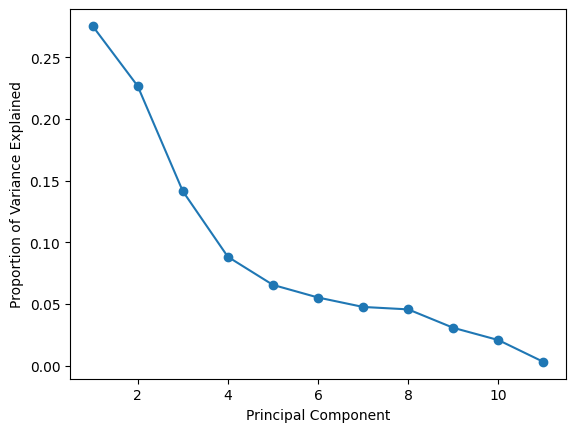

In [ ]:
fullpca = PCA().fit(zscore(survqs))

# Scree plot to choose the best number of components

plt.plot(np.arange(1, len(fullpca.explained_variance_ratio_) + 1), fullpca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [ ]:
# PCA with 3 components. The number of components we choose is 3 based on the scree plot
f3 = PCA(n_components=3).fit_transform(zscore(survqs))

(3.0, 9.0)

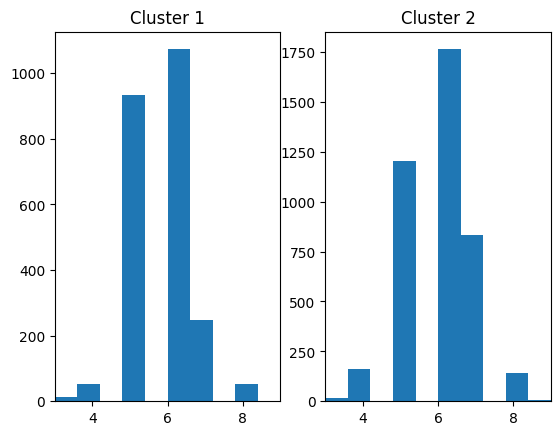

In [ ]:
#Set the number of clusters K=2
fsc3 = KMeans(n_clusters=2).fit(f3)
plt.subplot(1, 2, 1)
plt.hist(wine.quality[ fsc3.labels_ == 0]) #labels=0: cluster 1
plt.title('Cluster 1')
plt.xlim([3,9])
plt.subplot(1, 2, 2)
plt.hist(wine.quality[ fsc3.labels_ == 1])
plt.title('Cluster 2')
plt.xlim([3,9])



PCA Analysis

In [ ]:
# Standardize the data
features_scaled = zscore(survqs)

# Perform PCA to reduce dimensionality for visualization
pca = PCA(n_components=3)
principal_components = pca.fit_transform(features_scaled)

# Add principal components to the dataframe
wine['PC1'] = principal_components[:, 0]
wine['PC2'] = principal_components[:, 1]



In [ ]:
#count of numbers of red and white wines in each cluster
wine['cluster'] = fsc3.labels_
cluster_counts = wine.groupby(['color', 'cluster']).size().unstack(fill_value=0)
print(cluster_counts)

cluster     0     1
color              
red        18  1581
white    2353  2545


In [ ]:
#proportion in each cluster
cluster_proportions = cluster_counts.div(cluster_counts.sum(axis=1), axis=0)
print(cluster_proportions)

cluster         0         1
color                      
red      0.011257  0.988743
white    0.480400  0.519600


In [ ]:
red_proportions_per_cluster = cluster_counts.loc['red'] / cluster_counts.sum(axis=0)
print(red_proportions_per_cluster)


cluster
0    0.007592
1    0.383180
dtype: float64


                count      mean       std  min  25%  50%  75%  max
cluster color                                                     
0       red      18.0  5.500000  0.707107  5.0  5.0  5.0  6.0  7.0
        white  2353.0  5.699108  0.796188  3.0  5.0  6.0  6.0  9.0
1       red    1581.0  5.637571  0.808706  3.0  5.0  6.0  6.0  8.0
        white  2545.0  6.043222  0.931043  3.0  5.0  6.0  7.0  9.0


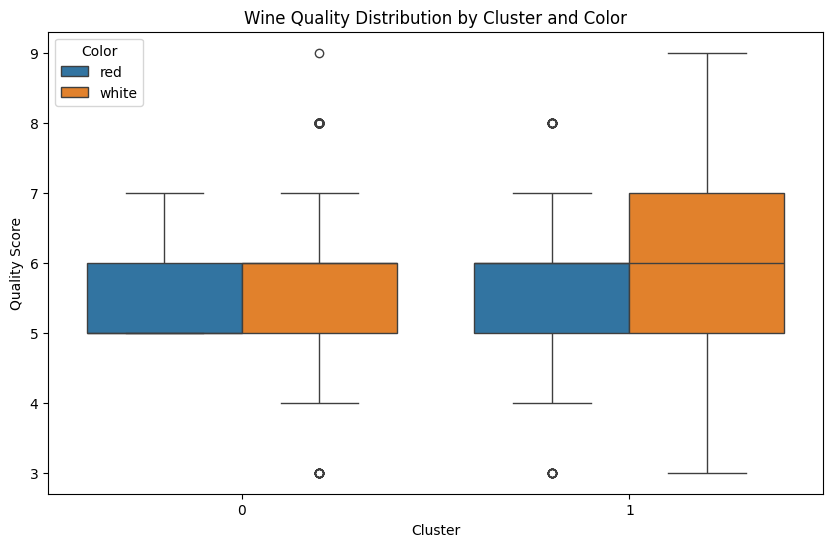

In [ ]:

# Group by cluster and color
grouped = wine.groupby(['cluster', 'color'])

# Calculate summary statistics
summary_stats = grouped['quality'].describe()
print(summary_stats)

# Visualize the data
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='quality', hue='color', data=wine)
plt.title('Wine Quality Distribution by Cluster and Color')
plt.xlabel('Cluster')
plt.ylabel('Quality Score')
plt.legend(title='Color')
plt.show()


According to the proportion, cluster 0 has far more less red wines than white wines. And for cluster 1, majority of the wines are red wines

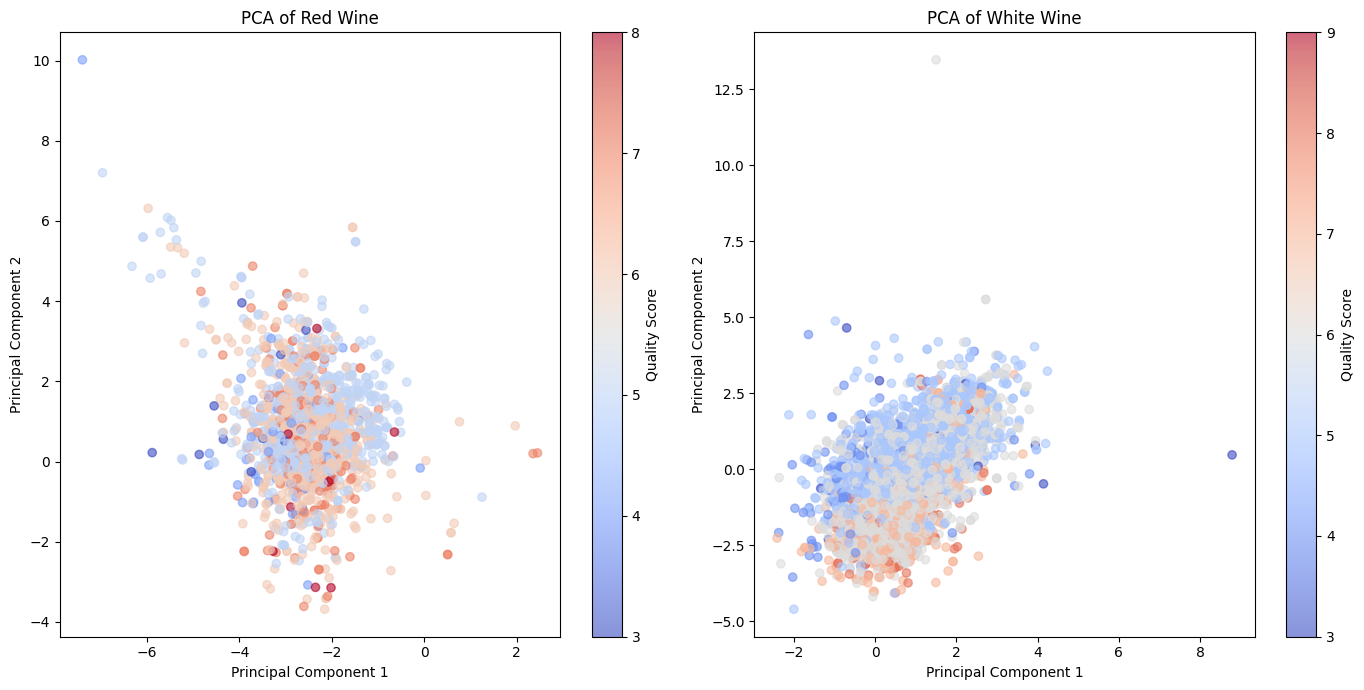

In [ ]:
# Plot the PCA results, colored by wine color and quality score
plt.figure(figsize=(14, 7))

# Plot for red wine
plt.subplot(1, 2, 1)
red_wine = wine[wine['color'] == 'red']
plt.scatter(red_wine['PC1'], red_wine['PC2'], c=red_wine['quality'], cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Quality Score')
plt.title('PCA of Red Wine')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot for white wine
plt.subplot(1, 2, 2)
white_wine = wine[wine['color'] == 'white']
plt.scatter(white_wine['PC1'], white_wine['PC2'], c=white_wine['quality'], cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Quality Score')
plt.title('PCA of White Wine')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()


In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])


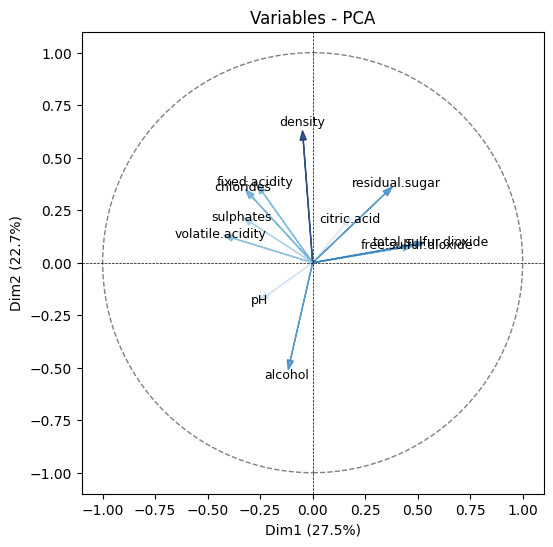

In [ ]:
# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features_scaled)

# PCA loadings (i.e., variable contributions)
loadings = pca.components_.T

# Cos2 = squared coordinates of the variables divided by the length squared (quality of representation)
cos2 = np.sum(loadings**2, axis=1)

# Start plotting with locked aspect ratio
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)

# Feature names for labeling
feature_names = features_scaled.columns

# Plot arrows and labels
for i, (x, y) in enumerate(loadings):
    ax.arrow(0, 0, x, y, color=plt.cm.Blues(cos2[i]/max(cos2)), alpha=0.8, head_width=0.03)
    ax.text(x * 1.15, y * 1.15, feature_names[i], ha='center', va='center', fontsize=9)

# Add unit circle
circle = plt.Circle((0, 0), 1, edgecolor='gray', linestyle='--', fill=False)
ax.add_patch(circle)

# Axes formatting
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.axvline(0, color='black', linestyle='--', linewidth=0.5)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_aspect('equal')

# Labels
ax.set_xlabel(f'Dim1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'Dim2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('Variables - PCA')

plt.show()


<ipython-input-19-82e066094266>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', n_clusters)


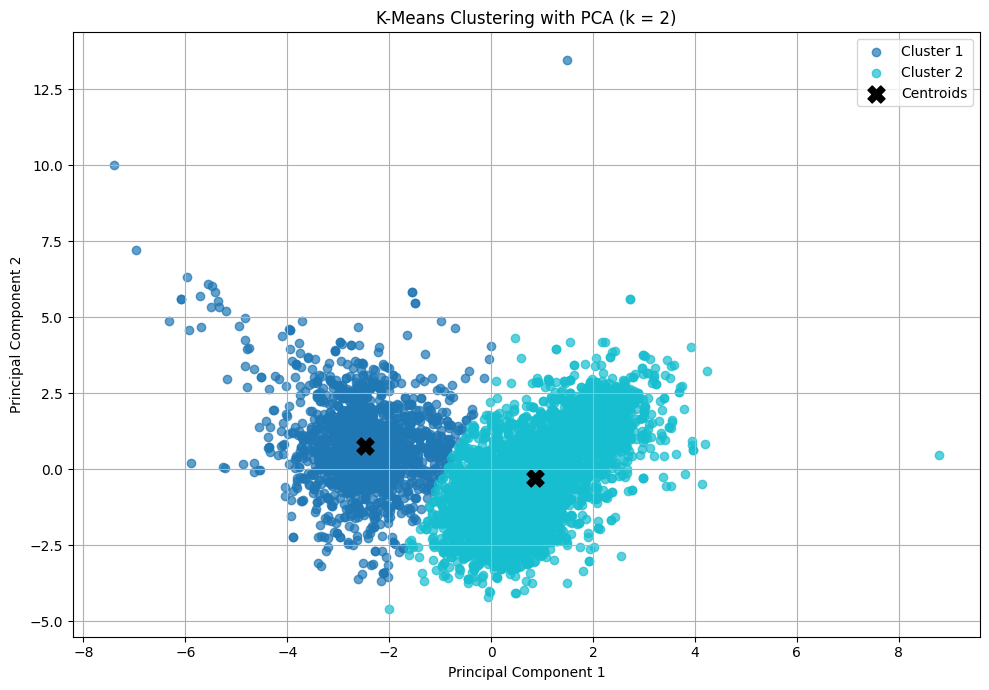

In [ ]:
import matplotlib.cm as cm
n_clusters = 2  # You can change this number as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(pca_result)


pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

colors = cm.get_cmap('tab10', n_clusters)

plt.figure(figsize=(10, 7))

for i, cluster_label in enumerate(sorted(pca_df['Cluster'].unique())):
    cluster_points = pca_df[pca_df['Cluster'] == cluster_label]
    plt.scatter(cluster_points['PC1'], cluster_points['PC2'],
                label=f'Cluster {i+1}', alpha=0.7, color=colors(i))


centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=150, marker='X', label='Centroids')


plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"K-Means Clustering with PCA (k = {n_clusters})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
